# Topology in 2D / From topological superconductivity and back

In [1]:
%matplotlib inline
from copy import copy

import numpy as np
from matplotlib import pyplot
import kwant
import kwant.continuum
from pfaffian import pfaffian

import ipywidgets

pi = np.pi

In [2]:
def interact(function, **params):
    params_spec = {
        key: ipywidgets.FloatText(value=value, step=0.05)
        for key, value in params.items()
    }
    return ipywidgets.interactive(function, **params_spec)

def interval_shape(x_min, x_max):
    def shape(site):
        return x_min <= site.pos[0] < x_max
    
    return shape

def const(value):
    return lambda *_: value

In [3]:
sigma_0 = np.eye(2)
sigma_x = np.array(
    [[0, 1],
     [1, 0]]
)
sigma_y = np.array(
    [[0, -1j],
     [1j, 0]]
)
sigma_z = np.array(
    [[1, 0],
     [0, -1]]
)

In [4]:
### Sparse diagonalization, details aren't important
### taken from https://gitlab.kwant-project.org/qt/cookbook

import scipy.sparse.linalg as sla
from scipy.sparse import identity
import kwant.linalg.mumps as mumps


def sparse_diag(matrix, k, sigma, **kwargs):
    """Call sla.eigsh with mumps support.

    Please see scipy.sparse.linalg.eigsh for documentation.
    """
    class LuInv(sla.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A, ordering='pord')
            inst.factor(A)
            self.solve = inst.solve
            sla.LinearOperator.__init__(self, A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    opinv = LuInv(matrix - sigma * identity(matrix.shape[0]))
    return sla.eigsh(matrix, k, sigma=sigma, OPinv=opinv, **kwargs)


## 2D $p$-wave superconductor

In [5]:
p_wave_hamiltonian = """
    (k_x**2 + k_y**2 - mu) * sigma_z 
    + Delta * (k_x * sigma_x + k_y * sigma_y)
"""

p_wave_template = kwant.continuum.discretize(p_wave_hamiltonian)

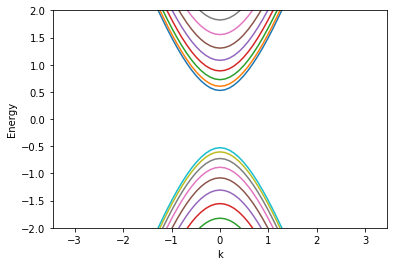

In [6]:
ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, 1]))

ribbon.fill(
    p_wave_template,
    shape=interval_shape(-10, 10),
    start=[0, 0]
)

kwant.plotter.bands(
    ribbon.finalized(),
    params=dict(
        mu=-0.5,
        Delta=.5
    ),
    show=False
)
pyplot.ylim(-2, 2);

There are edge states in a topological regime, let's see how they look.

In [7]:
def circle(site):
    return np.linalg.norm(site.pos) < 20

p_wave_disk = kwant.Builder()
p_wave_disk.fill(
    p_wave_template,
    shape=circle,
    start=[0, 0]
);

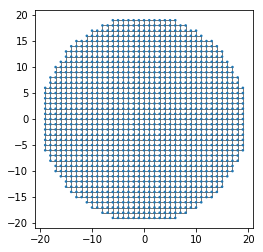

In [8]:
p_wave_disk_finalized = p_wave_disk.finalized()
kwant.plot(p_wave_disk);

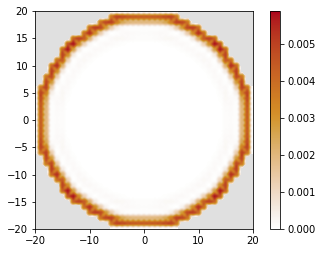

/home/anton/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [9]:
params=dict(
    mu=1,
    Delta=1.
)

E, psi = sparse_diag(
    p_wave_disk_finalized.hamiltonian_submatrix(
        sparse=True,
        params=params
    ),
    k=1,
    sigma=0
)

Q = kwant.operator.Density(p_wave_disk_finalized)
density = Q(psi[:, 0])
kwant.plotter.density(p_wave_disk_finalized, density);

# J = kwant.operator.Current(p_wave_disk_finalized)
# current = J(psi[:, 0], params=params)
# kwant.plotter.current(p_wave_disk_finalized, current);

Adding a vortex to create a Majorana bound state

In [10]:
list(p_wave_template.hopping_value_pairs())

[((Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.0, 1.0]], [0.0, 0.0], '', 2), array([0, 0])),
   Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.0, 1.0]], [0.0, 0.0], '', 2), array([1, 0]))),
  <function hopping_1(site1, site2, Delta)>),
 ((Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.0, 1.0]], [0.0, 0.0], '', 2), array([0, 0])),
   Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.0, 1.0]], [0.0, 0.0], '', 2), array([0, 1]))),
  <function hopping_2(site1, site2, Delta)>)]

In [11]:
hop_x = next(p_wave_template.hopping_value_pairs())[1]
hop_x

<function hopping_1(site1, site2, Delta)>

In [12]:
def hopping_with_pi_phase(site1, site2, Delta):
    return -hop_x(site1, site2, Delta)

for (end_site, start_site) in p_wave_disk.hoppings():
    if start_site.tag[0] == 1 and end_site.tag[0] == 0 and start_site.tag[1] < 0:
        p_wave_disk[end_site, start_site] = hopping_with_pi_phase

In [13]:
p_wave_disk_finalized = p_wave_disk.finalized()

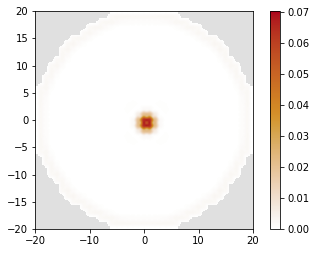

/home/anton/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [14]:
params=dict(
    mu=1,
    Delta=1.
)

E, psi = sparse_diag(
    p_wave_disk_finalized.hamiltonian_submatrix(
        sparse=True,
        params=params
    ),
    k=1,
    sigma=0
)

Q = kwant.operator.Density(p_wave_disk_finalized)
density = Q(psi[:, 0])
kwant.plotter.density(p_wave_disk_finalized, density);

# J = kwant.operator.Current(p_wave_disk_finalized)
# current = J(psi[:, 0], params=params)
# kwant.plotter.current(p_wave_disk_finalized, current);

## $p$-wave to QAHE

The particle-hole symmetry is unimportant for topology here: the chiral edge state cannot be scattered

$\Rightarrow$ break PHS and get a quantum anomalous Hall insulator

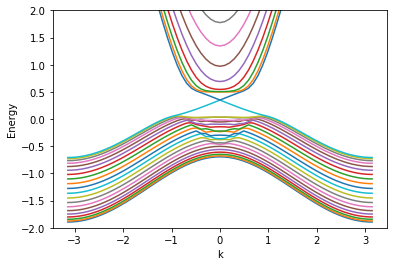

In [15]:
qah_hamiltonian = """
    (k_x**2 + k_y**2 - mu) * sigma_z 
    + Delta * (k_x * sigma_x + k_y * sigma_y)
    + delta_m * (k_x**2 + k_y**2) * sigma_0
"""

qah_template = kwant.continuum.discretize(qah_hamiltonian)

ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, 1]))

ribbon.fill(
    qah_template,
    shape=interval_shape(-10, 10),
    start=[0, 0]
)

kwant.plotter.bands(
    ribbon.finalized(),
    params=dict(
        mu=0.5,
        Delta=.5,
        delta_m=.7
    ),
    show=False
)
pyplot.ylim(-2, 2);

## QAHE to QSHE

Adding time-reversal symmetry by doubling the model

In [16]:
qshe_hamiltonian = """
    (k_x**2 + k_y**2 - mu) * kron(sigma_z, sigma_0)
    + Delta * (k_x * kron(sigma_x, sigma_z) + k_y * kron(sigma_y, sigma_0))
    + delta_m * (k_x**2 + k_y**2) * identity(4)
"""

trs = np.kron(sigma_0, sigma_y)

qshe_template = kwant.continuum.discretize(qshe_hamiltonian)

ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, 1]), time_reversal=trs)

ribbon.fill(
    qshe_template,
    shape=interval_shape(-10, 10),
    start=[0, 0]
);

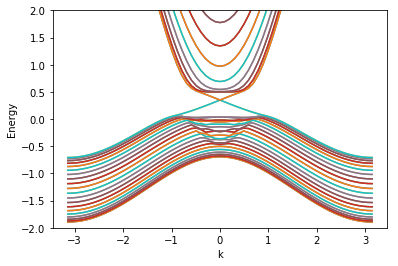

In [17]:
kwant.plotter.bands(
    ribbon.finalized(),
    params=dict(
        mu=0.5,
        Delta=.5,
        delta_m=.7
    ),
    show=False
)
pyplot.ylim(-2, 2);

Let's try to couple the spins without breaking TRS

In [18]:
spin_orbit = np.kron(sigma_y, sigma_y)

trs @ spin_orbit @ trs - spin_orbit  # Preserves time-reversal

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [21]:
spin_orbit = "alpha * kron(sigma_y, sigma_y)"

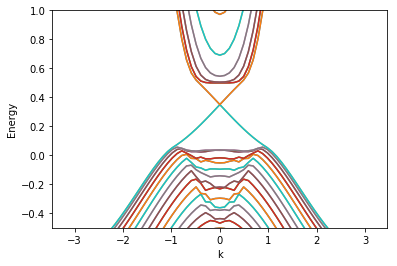

In [23]:
qshe_template = kwant.continuum.discretize(qshe_hamiltonian + "+" + spin_orbit)

ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, 1]), time_reversal=trs)

ribbon.fill(
    qshe_template,
    shape=interval_shape(-10, 10),
    start=[0, 0]
)

kwant.plotter.bands(
    ribbon.finalized(),
    params=dict(
        mu=0.5,
        Delta=.5,
        delta_m=.7,
        alpha=0,
    ),
    show=False
)
pyplot.ylim(-.5, 1);

Edge states stay protected because of topological protection.

To couple them, we need to break TRS.

In [24]:
zeeman = 'kron(sigma_0, B_z * sigma_z + B_x * sigma_x + B_y * sigma_y)'

# Not accurate, g-factors are very anisotropic and different bands couple differently

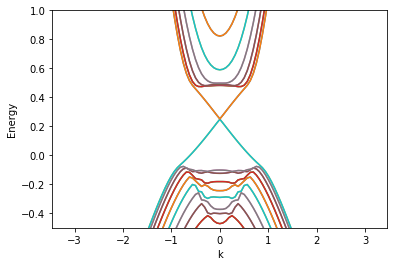

In [25]:
qshe_template = kwant.continuum.discretize(qshe_hamiltonian + "+" + spin_orbit + "+" + zeeman)

ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, 1]), time_reversal=trs)

ribbon.fill(
    qshe_template,
    shape=interval_shape(-10, 10),
    start=[0, 0]
)

kwant.plotter.bands(
    ribbon.finalized(),
    params=dict(
        mu=0.5,
        Delta=.5,
        delta_m=.5,
        alpha=0.0,
        B_x=0,
        B_y=0,
        B_z=0,
    ),
    momenta=101,
    show=False
)
pyplot.ylim(-.5, 1);

Caveat: edge states may be "buried"!

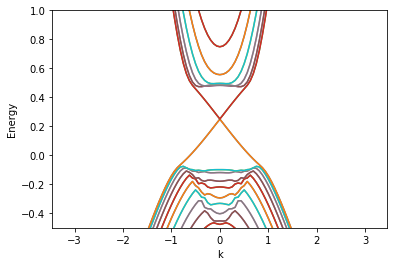

In [26]:
qshe_template = kwant.continuum.discretize(qshe_hamiltonian + ' + V(x) * identity(4)')

ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, 1]), time_reversal=trs)

ribbon.fill(
    qshe_template,
    shape=interval_shape(-10, 11),
    start=[0, 0]
)
                                           
def V(x):
    if abs(x) < 9.5:
        return 0
    else:
        return 0
    

kwant.plotter.bands(
    ribbon.finalized(),
    params=dict(
        mu=0.5,
        Delta=.5,
        delta_m=.5,
        V=V
    ),
    momenta=101,
    show=False
)
pyplot.ylim(-.5, 1);

## Final step: adding superconductivity and QSHE

Let's combine everything together and try to make Majoranas again!

In [27]:
qshe_sc_hamiltonian = f'''
    kron({qshe_hamiltonian.replace("mu", "delta").replace('Delta', 'alpha')}    - mu * identity(4), sigma_z)
    + kron({zeeman}, sigma_0)
    + Delta * kron(identity(4), sigma_x)
'''

qshe_sc_normal = f'''
    kron({qshe_hamiltonian.replace("mu", "delta").replace('Delta', 'alpha')}    - mu * identity(4), sigma_z)
    + kron({zeeman}, sigma_0)
'''

qshe_sc_no_B = f'''
    kron({qshe_hamiltonian.replace("mu", "delta").replace('Delta', 'alpha')}    - mu * identity(4), sigma_z)
    + Delta * kron(identity(4), sigma_x)
'''


print(qshe_sc_hamiltonian)


    kron(
    (k_x**2 + k_y**2 - delta) * kron(sigma_z, sigma_0)
    + alpha * (k_x * kron(sigma_x, sigma_z) + k_y * kron(sigma_y, sigma_0))
    + delta_m * (k_x**2 + k_y**2) * identity(4)
    - mu * identity(4), sigma_z)
    + kron(kron(sigma_0, B_z * sigma_z + B_x * sigma_x + B_y * sigma_y), sigma_0)
    + Delta * kron(identity(4), sigma_x)



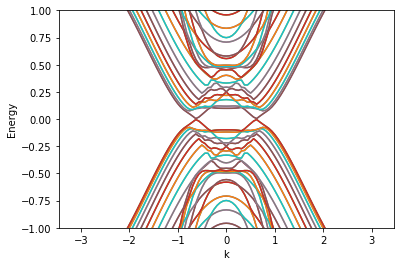

In [28]:
qshe_sc_template = kwant.continuum.discretize(qshe_sc_hamiltonian)

ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, 1]))

ribbon.fill(
    qshe_sc_template,
    shape=interval_shape(-10, 11),
    start=[0, 0]
)    

kwant.plotter.bands(
    ribbon.finalized(),
    params=dict(
        delta=0.5,
        alpha=.5,
        delta_m=.5,
        B_x=0,
        B_y=0,
        B_z=0,
        Delta=0,
        mu=0,
    ),
    momenta=101,
    show=False
)
pyplot.ylim(-1, 1);

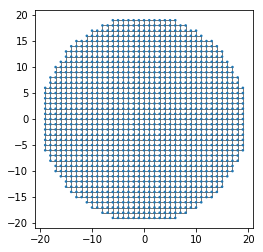

In [29]:
def left_half_circle(site):
    pos = site.pos
    return np.linalg.norm(pos) < 20 and pos[0] < 0

hybrid = kwant.Builder()
hybrid.fill(
    kwant.continuum.discretize(qshe_sc_no_B),
    shape=left_half_circle,
    start=[-1, 0]
);

hybrid.fill(
    kwant.continuum.discretize(qshe_sc_normal),
    shape=circle,
    start=[1, 0]
);

hybrid_finalized = hybrid.finalized()
kwant.plot(hybrid_finalized);

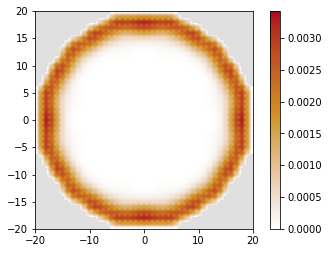

/home/anton/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [30]:
params=dict(
    delta=0.5,
    alpha=.5,
    delta_m=.5,
    B_x=0,
    B_y=0,
    B_z=0,
    Delta=0,
    mu=0,
)

E, psi = sparse_diag(
    hybrid_finalized.hamiltonian_submatrix(
        sparse=True,
        params=params
    ),
    k=1,
    sigma=0
)

Q = kwant.operator.Density(hybrid_finalized)
density = Q(psi[:, 0])
kwant.plotter.density(hybrid_finalized, density);


## An example from practice

[**External illustration**]

Code from [arXiv:1809.09050](https://arxiv.org/abs/1809.09050)

## Conclusions

- $p$-wave superconductors have a chiral edge mode
- Vortices introduce Majoranas
- Same model (quadratic band + Dirac term) applies to other symmetry classes as well
- Edge states may be "buried", which makes inducing a gap impossible
- Domain walls between magnetic gap and superconducting gap in QSHE induce Majoranas

## Exercises

#### Coupling the edges

1. Define a scattering geometry using the quantum anomalous Hall Hamiltonian.
2. Observe that the conductance through the device is quantized (as it should)
3. Introduce a defect in the middle of the device, so that the two edge states couple.
4. Observe how the conductance through the device drops as the barrier is increased, plot the current density


#### $p$-wave from QAH

1. Add superconducting pairing to the QAH Hamiltonian.
    - Because it has no time-reversal symmetry, there are many ways to introduce the pairing.
    - If you want to have an easy solution, take the Hamiltonian from [arXiv:1809.09050](https://arxiv.org/abs/1809.09050)
2. Observe that depending on the superconducting pairing, one may cause a topological phase transition and create chiral Majorana modes
3. Create a ribbon with a superconductor covering one part of it, so that there is a chiral Majorana state in the middle